In [ ]:
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm
from Model import Hierarchical_network
import numpy as np
bm.set(dt=0.05)

data = np.load('trajectory_test.npz')
    
# 提取各个矩阵
loc = data['position']
velocity = data['velocity']
speed = data['speed']
head_direction = velocity/speed[:,np.newaxis]
rot_vel = data['rot_vel']

Hierarchical_net = Hierarchical_network(num_module=5, num_place=30)
def initialize(i, input_stre):
    Hierarchical_net.step_run(i, velocity = bm.zeros(2,), loc=loc[0], loc_input_stre = input_stre)

init_time = 500
indices = bm.arange(init_time)
input_stre = bm.zeros(init_time) 
input_stre[:400] = 100.
bm.for_loop(initialize, (indices, input_stre), progress_bar=True)

def run(i, vel, loc):
    Hierarchical_net.step_run(i, velocity = vel, loc=loc, loc_input_stre = 0.)
    band_x_r = Hierarchical_net.band_x_fr
    band_y_r = Hierarchical_net.band_y_fr
    grid_r = Hierarchical_net.grid_fr
    place_r = Hierarchical_net.place_fr
    return band_x_r, band_y_r, grid_r, place_r
total_time = velocity.shape[0]
indices = bm.arange(total_time)
band_x_r, band_y_r, grid_r, place_r = bm.for_loop(run, (indices, velocity, loc), progress_bar=True)
# save the neuron activity
np.savez('band_grid_place_activity.npz', band_x_r=band_x_r, band_y_r=band_y_r, grid_r=grid_r, place_r=place_r)

d:\anaconda3\envs\CANNs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running for 300,000 iterations: 100%|██████████| 300000/300000 [09:30<00:00, 525.54it/s]


In [2]:
# from Calculate_heatmap import compute_firing_field
from numba import njit, prange
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit
from numba import prange
from funcs import gauss_filter
@njit(parallel=True)
def compute_firing_field(A, positions, width, height, M, K):
    T, N = A.shape  # Number of time steps and neurons
    # Initialize the heatmaps and bin counters
    heatmaps = np.zeros((N, M, K))
    bin_counts = np.zeros((M, K))

    # Determine bin sizes
    bin_width = width / M
    bin_height = height / K
    # Assign positions to bins
    x_bins = np.clip(((positions[:, 0]) // bin_width).astype(np.int32), 0, M - 1)
    y_bins = np.clip(((positions[:, 1]) // bin_height).astype(np.int32), 0, K - 1)

    # Accumulate activity in each bin
    for t in prange(T):
        x_bin = x_bins[t]
        y_bin = y_bins[t]
        heatmaps[:, x_bin, y_bin] += A[t, :]
        bin_counts[x_bin, y_bin] += 1

    # Compute average firing rate per bin (avoid division by zero)
    for n in range(N):
        heatmaps[n] = np.where(bin_counts>0, heatmaps[n]/bin_counts, 0)
    
    return heatmaps
grid_r = np.array(grid_r)
band_x_r = np.array(band_x_r)
band_y_r = np.array(band_y_r)
place_r = np.array(place_r)
loc = np.array(loc)
width = 5
height = 5
M = int(width*10)
K = int(height*10)
T = grid_r.shape[0]
grid_r = grid_r.reshape(T, -1)
band_x_r = band_x_r.reshape(T, -1)
band_y_r = band_y_r.reshape(T, -1)
heatmaps_grid = compute_firing_field(grid_r, loc, width, height, M, K)
heatmaps_band_x = compute_firing_field(band_x_r, loc, width, height, M, K)
heatmaps_band_y = compute_firing_field(band_y_r, loc, width, height, M, K)
heatmaps_place = compute_firing_field(place_r, loc, width, height, M, K)
# save the heatmap
np.savez('band_grid_place_heatmap.npz', heatmaps_grid=heatmaps_grid, heatmaps_band_x=heatmaps_band_x, heatmaps_band_y=heatmaps_band_y, heatmaps_place=heatmaps_place)

In [3]:

heatmaps_grid = gauss_filter(heatmaps_grid)
heatmaps_band_x = gauss_filter(heatmaps_band_x)
heatmaps_band_y = gauss_filter(heatmaps_band_y)
heatmaps_place = gauss_filter(heatmaps_place)

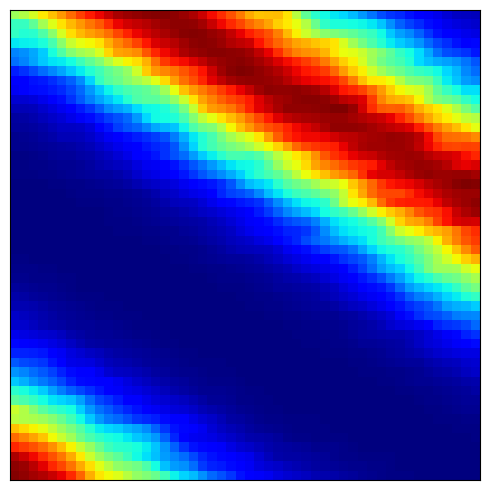

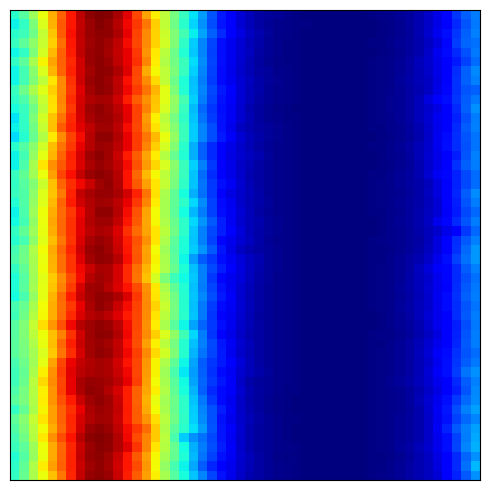

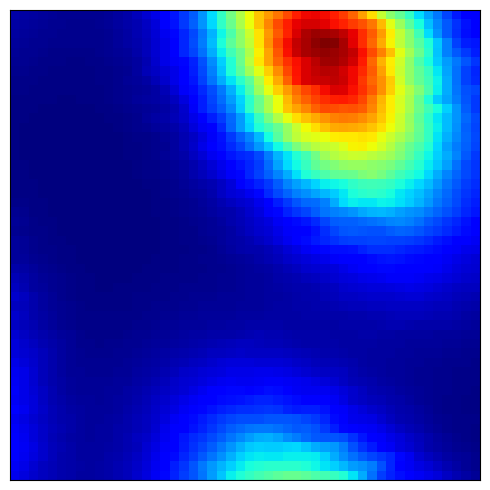

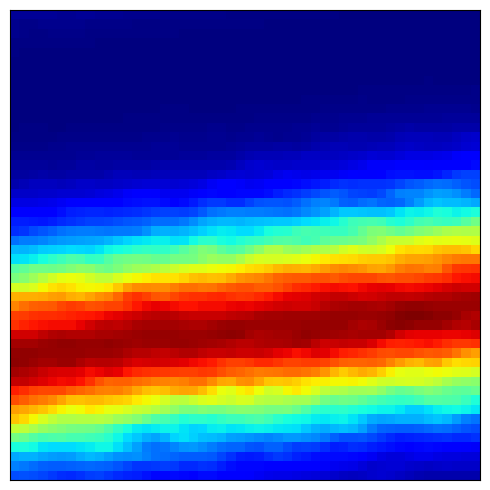

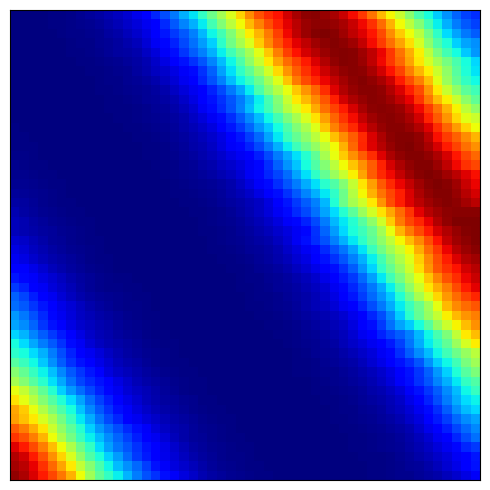

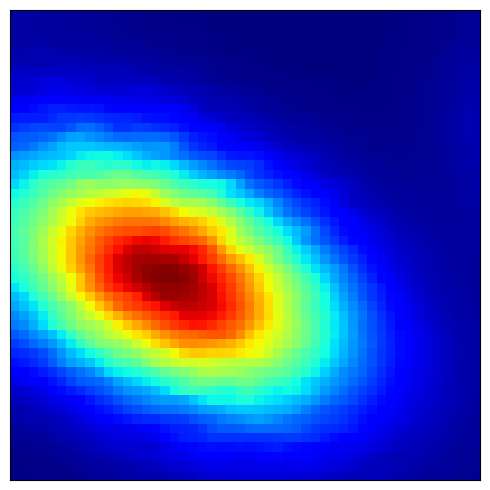

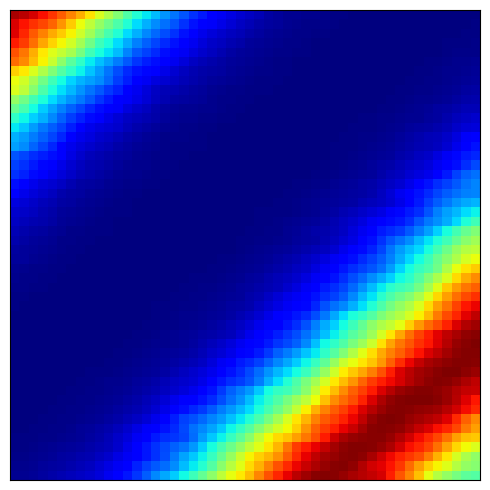

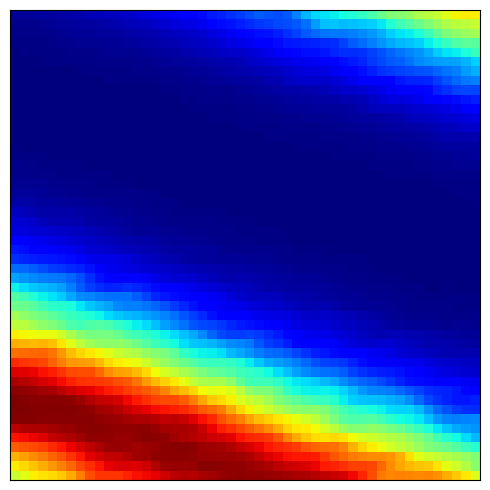

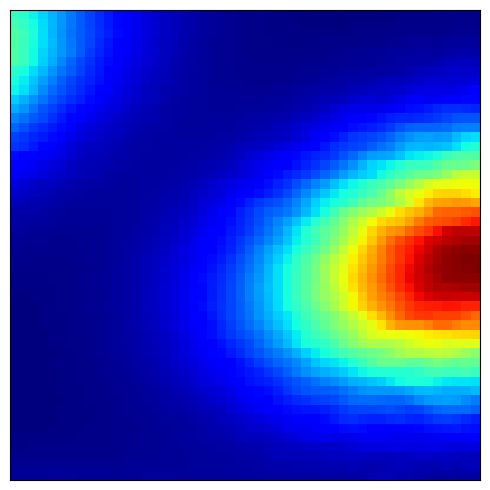

In [4]:
heatmaps_band_x = heatmaps_band_x.reshape(5,-1, M, K)
heatmaps_band_y = heatmaps_band_y.reshape(5,-1, M, K)
heatmaps_grid = heatmaps_grid.reshape(5,-1, M, K)

# plot the heatmap
probe_index = 112
for module_index in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmaps_band_x[module_index,probe_index].T, cmap='jet', interpolation='nearest', origin='lower')
    # plt.title('Band module 1')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    figname = 'heatmap_band_1_module_{}.png'.format(module_index)
    plt.savefig(figname)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(heatmaps_band_y[module_index,probe_index].T, cmap='jet', interpolation='nearest', origin='lower')
    # plt.title('Band module 2')
    # 去除 x 轴和 y 轴的刻度
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    figname = 'heatmap_band_2_module_{}.png'.format(module_index)
    plt.savefig(figname)

    plt.figure(figsize=(5, 5))
    plt.imshow(heatmaps_grid[module_index,probe_index].T, cmap='jet', interpolation='nearest', origin='lower')
    # plt.title('Grid cell')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    figname = 'heatmap_grid_module_{}.png'.format(module_index)
    plt.savefig(figname)

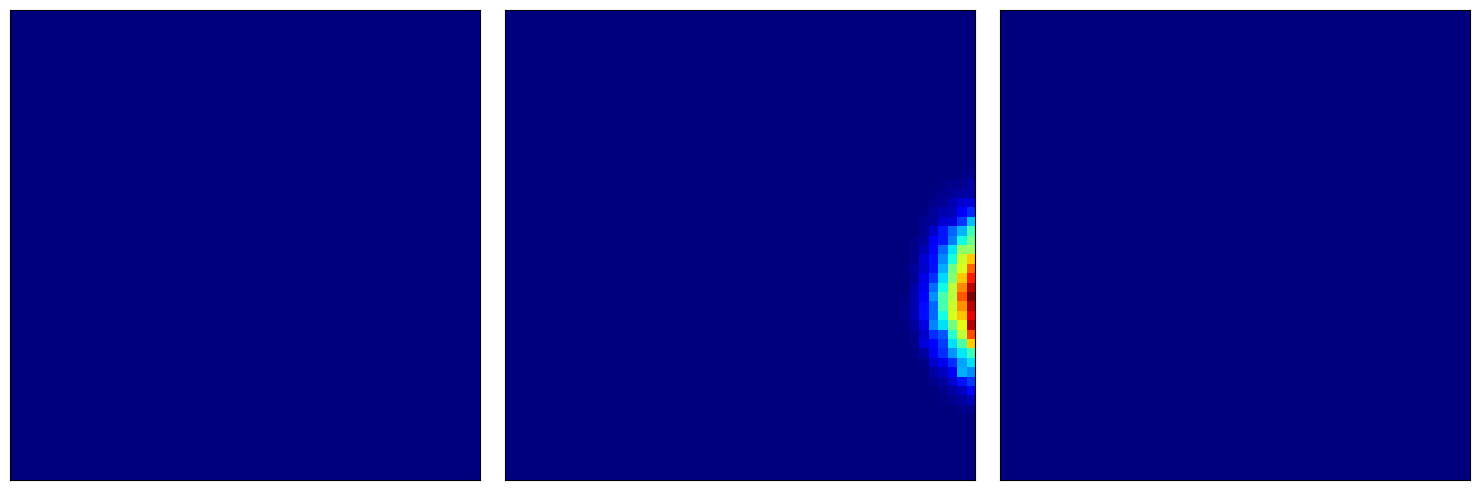

In [5]:

# load the data
data = np.load('band_grid_place_heatmap.npz')
heatmaps_place = data['heatmaps_place']
# plot the data
# plot three cells, random shuffle 3 cells for 800
probe_index = np.random.choice(heatmaps_place.shape[0], 3, replace=False)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, probe_index in enumerate(probe_index):
    ax[i].imshow(heatmaps_place[probe_index].T, cmap='jet', interpolation='nearest', origin='lower')
    # ax[i].set_title(f'Place cell {i+1}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('heatmap_place.png')